In [1]:
from google.colab import files
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d spscientist/students-performance-in-exams
!unzip students-performance-in-exams.zip

Saving kaggle.json to kaggle.json
  0% 0.00/8.70k [00:00<?, ?B/s]
100% 8.70k/8.70k [00:00<00:00, 3.28MB/s]
Archive:  students-performance-in-exams.zip
  inflating: StudentsPerformance.csv  


In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
sns.set_style('darkgrid')

In [3]:
df = pd.read_csv('StudentsPerformance.csv')
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


# Data Division for prediction
We divide students in Pass and NotPass the maths exam (Score to pass: 50)

In [4]:
classes = []
for i in df['writing score']:
  if i < 50:
    classes.append('not_pass')
  else:
    classes.append('pass')
df['Result'] = classes
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,Result
0,female,group B,bachelor's degree,standard,none,72,72,74,pass
1,female,group C,some college,standard,completed,69,90,88,pass
2,female,group B,master's degree,standard,none,90,95,93,pass
3,male,group A,associate's degree,free/reduced,none,47,57,44,not_pass
4,male,group C,some college,standard,none,76,78,75,pass


Eliminate the another exams scores as they are no needed in the analysis

In [5]:
df.drop(['math score', 'reading score'], axis=1, inplace=True)

Lets see some characteristics of each class in Result (pass or not pass)

Percentage of the data
Result
not_pass    11.4
pass        88.6
Name: writing score, dtype: float64
Maximum
Result
not_pass     49
pass        100
Name: writing score, dtype: int64
Minimum
Result
not_pass    10
pass        50
Name: writing score, dtype: int64




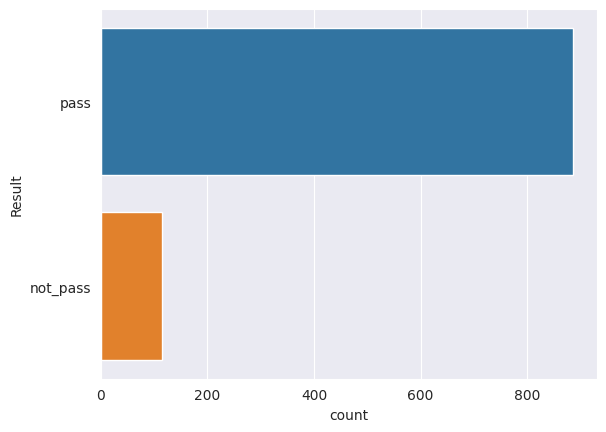

In [6]:
print('Percentage of the data')
print(df.groupby(by='Result')['writing score'].count()/len(df)*100)
print('='*30)

print('Maximum')
print(df.groupby(by='Result')['writing score'].max())
print('='*30)

print('Minimum')
print(df.groupby(by='Result')['writing score'].min())
print('\n')
sns.countplot(df, y='Result', hue='Result')
plt.show()

# Preparing data for ml

In [7]:
# Divide X and y (train and target)
X = df.iloc[:,:5].copy()
y = df['Result'].copy()

# Transform pass and not pass to 1 and 0
y = y.replace(['not_pass','pass'], [0,1])

In [8]:
#Apply OneHotEncoder to each feature
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='error')
enc.fit(X)
X_enc_array = enc.transform(X).toarray()

X_enc = pd.DataFrame(X_enc_array, columns=enc.get_feature_names_out())

enc.categories_
#X_enc

[array(['female', 'male'], dtype=object),
 array(['group A', 'group B', 'group C', 'group D', 'group E'],
       dtype=object),
 array(["associate's degree", "bachelor's degree", 'high school',
        "master's degree", 'some college', 'some high school'],
       dtype=object),
 array(['free/reduced', 'standard'], dtype=object),
 array(['completed', 'none'], dtype=object)]

## Train test split

shape of train: (700, 18)
shape of test: (300, 18)




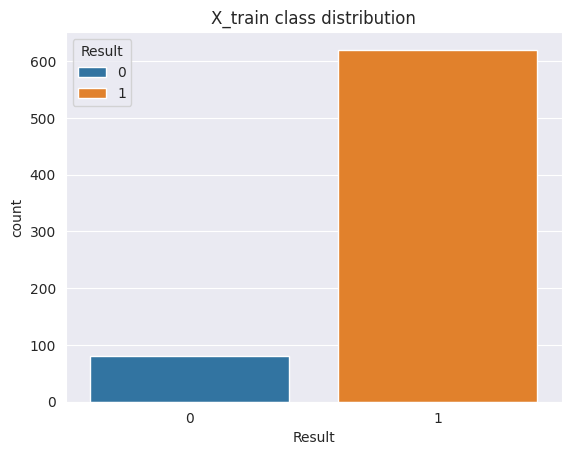

In [9]:
from sklearn.model_selection import train_test_split
# We made a stratify division on train and test as the target classes (pass\notpass) are inbalanced
X_train, X_test, y_train, y_test = train_test_split(X_enc,y, test_size= .3, random_state= 42, stratify=y, shuffle=True)

df_train = X_train.copy()
df_train['Result'] = y_train

df_test = X_test.copy()
df_test['Result'] = y_test


## Shape of the data
print(f'shape of train: {df_train.shape}')
print(f'shape of test: {df_test.shape}')
print('\n')

# Lets plot the train data to verify that the division has made stratified
plot_data = True
if plot_data:
  sns.countplot(df_train, x='Result',hue='Result')
  plt.title('X_train class distribution')
  plt.show()

## Under and Over sampling
Different type of Over and under sampling was prove. Between al was selected the SMOTE oversampling thanks to its good results

Also a random undersampling will be made on the test data. This because, the imbalanced data on the test, affect the accuaracy and do not let us to assess the "real" value

In [10]:
#undersampling
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_test_under, y_test_under = rus.fit_resample(X_test, y_test)
print(sorted(Counter(y_test_under).items()))

[(0, 34), (1, 34)]


In [11]:
#oversampling
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_bal_smote, y_bal_smote = sm.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_bal_smote))

Resampled dataset shape Counter({1: 620, 0: 620})


## Metrics functions
We define 2 functions:
- print_metrics: Print the report and heatmap of the results of the model. And append them to the lists(methods, accuaracy) for comparison
- print_metrics1: Makes the same of print_metrics, but do NOT append the results to the lists. Use for stationary view of the results

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score


def confucionMatrix(test,pred,classes):
  fig = plt.figure(figsize = (11,11))
  cm = confusion_matrix(test,pred, labels=classes)
  disp = ConfusionMatrixDisplay(confusion_matrix =cm, display_labels=classes)
  disp.plot(cmap=plt.cm.PuBuGn)
  plt.grid(False)
  plt.show()

In [13]:
methods = []
accuracy = []
def print_metrics(method,test,pred,classes,xtest):
  methods.append(method)
  print("Number of mislabeled points out of a total %d points : %d"
  % (xtest.shape[0], (test != pred).sum()))
  print("")
  a = accuracy_score(test,pred)
  accuracy.append(a)
  print(f"accuracy score: {a}")
  print("")
  confucionMatrix(test,pred,classes)
  print("")
  print(classification_report(test,pred))

def print_metrics1(test,pred,classes,xtest):
  print("Number of mislabeled points out of a total %d points : %d"
  % (xtest.shape[0], (test != pred).sum()))
  print("")
  a = accuracy_score(test,pred)
  print(f"accuracy score: {a}")
  print("")
  confucionMatrix(test,pred,classes)
  print("")
  print(classification_report(test,pred))

# Machine learning models
After think, try and prove different models on an apart test, was decided to use only that can give feature importance. This because, the target of this analysis is to identify wich features affect the more and need to be changed to decrease the number of aproved students

### Logistic Regression
After try different configurations this was the better:
- Use class weight to do a better classification of the not pass class as its the one that we are interested on


Number of mislabeled points out of a total 68 points : 16

accuracy score: 0.7647058823529411



<Figure size 1100x1100 with 0 Axes>

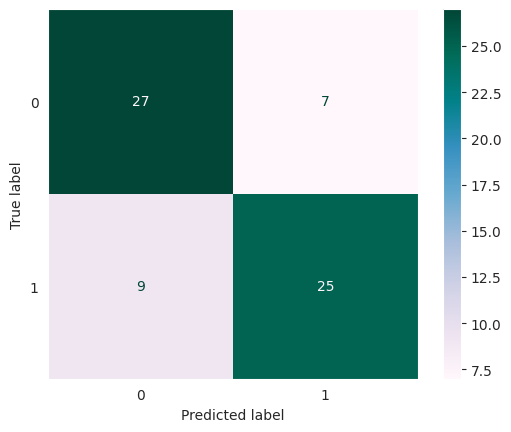


              precision    recall  f1-score   support

           0       0.75      0.79      0.77        34
           1       0.78      0.74      0.76        34

    accuracy                           0.76        68
   macro avg       0.77      0.76      0.76        68
weighted avg       0.77      0.76      0.76        68



In [50]:
from sklearn.linear_model import LogisticRegression
# On this case was seen that the use of class_weight get worst results, then it is no used
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg = LogisticRegression()
log_reg.fit(X_bal_smote, y_bal_smote)

logistic_predictions = log_reg.predict(X_test_under)
print_metrics1(y_test_under,logistic_predictions,log_reg.classes_,X_test_under)

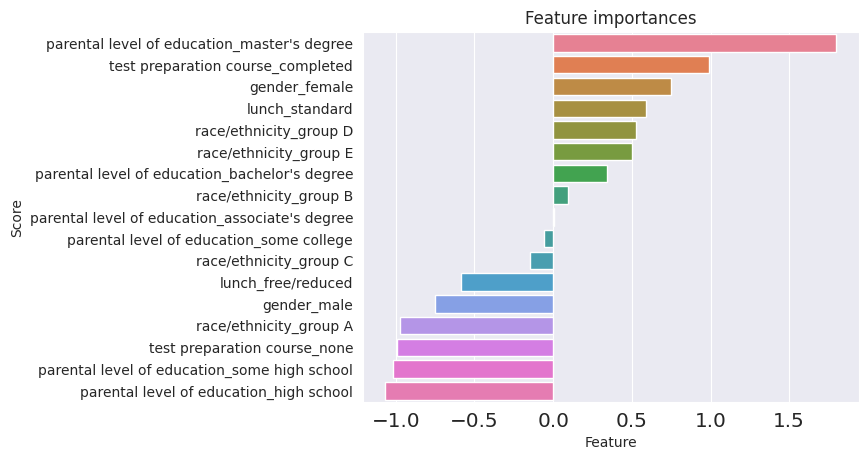

In [51]:
feature_importances = pd.DataFrame(
    {"feature":list(X_train.columns), 'importances':log_reg.coef_[0]}
).sort_values('importances',ascending=False)

sns.barplot(feature_importances, x='importances',y='feature',hue='feature')
plt.title('Feature importances')
plt.xlabel('Feature')
plt.ylabel('Score')
plt.xticks(fontsize='x-large')
plt.show()

## Random Forest:
1. We find the better parameters by using the code on tunning part
2. We use that parameters to train the model and construct the feature importance
3. Extra random models with the same parameters but without specifying the random state were constructed. This was made to see another diferent feature distributions. With them we can make more confident conclusion as the features repeated in most of the models are the most important ones

### Tunning: 2 stages
- We find the better fitted n_estimators by (random_forest = RandomForestClassifier(n_estimators=i , random_state=42))
- We find the better fitted max_depth by (random_forest = RandomForestClassifier(n_estimators=3, max_depth=i, random_state=42))

In [36]:
from sklearn.ensemble import RandomForestClassifier

X_probado = X_bal_smote
y_probado = y_bal_smote


estimators = []
y_train_acc_est = []
y_test_acc_est = []
for i in range(1,50):
  estimators.append(i)
  random_forest = RandomForestClassifier(n_estimators=3, max_depth=i, random_state=42)
  random_forest.fit(X_probado, y_probado)
  y_train_pred = random_forest.predict(X_probado)
  y_test_pred = random_forest.predict(X_test_under)

  y_train_acc = accuracy_score(y_probado,y_train_pred)
  y_test_acc = accuracy_score(y_test_under,y_test_pred)

  y_train_acc_est.append(y_train_acc)
  y_test_acc_est.append(y_test_acc)

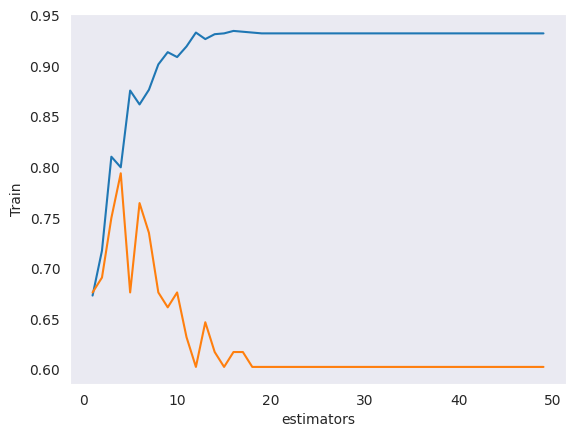

In [34]:
Est_data = pd.DataFrame({'estimators':estimators, 'Train':y_train_acc_est,'Test':y_test_acc_est})
sns.lineplot(Est_data, x = 'estimators', y = 'Train')
sns.lineplot(Est_data, x = 'estimators', y = 'Test')
plt.grid()
plt.show()

In [37]:
pd.DataFrame({"methods":estimators, "accuracy":y_test_acc_est}).sort_values(by="accuracy", ascending=False)

,methods,accuracy
3,4,0.794118
5,6,0.779412
6,7,0.764706
2,3,0.720588
7,8,0.720588
1,2,0.705882
9,10,0.691176
0,1,0.676471
4,5,0.676471
12,13,0.647059


### Model

Number of mislabeled points out of a total 68 points : 17

accuracy score: 0.75



<Figure size 1100x1100 with 0 Axes>

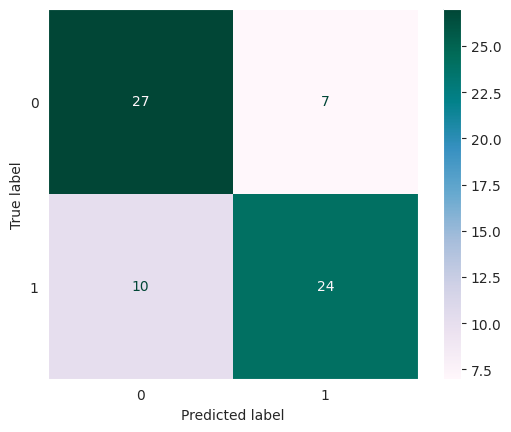


              precision    recall  f1-score   support

           0       0.73      0.79      0.76        34
           1       0.77      0.71      0.74        34

    accuracy                           0.75        68
   macro avg       0.75      0.75      0.75        68
weighted avg       0.75      0.75      0.75        68



In [56]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=3, max_depth=4)
rf.fit(X_bal_smote, y_bal_smote)
rf_predictions= rf.predict(X_test_under)

print_metrics1(y_test_under,rf_predictions,rf.classes_,X_test_under)

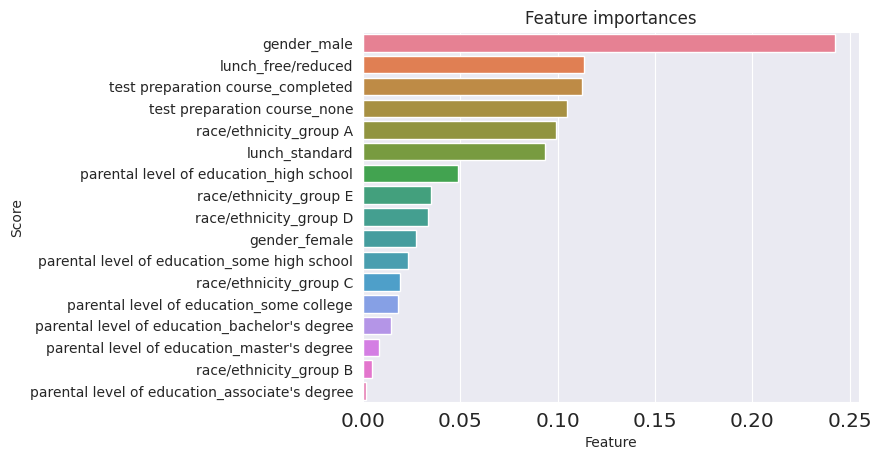

In [57]:
feature_importances = pd.DataFrame(
    {"feature":list(X_train.columns), 'importances':rf.feature_importances_}
).sort_values('importances',ascending=False)

sns.barplot(feature_importances, x='importances',y='feature',hue='feature')
plt.title('Feature importances')
plt.xlabel('Feature')
plt.ylabel('Score')
plt.xticks(fontsize='x-large')
plt.show()

0.75


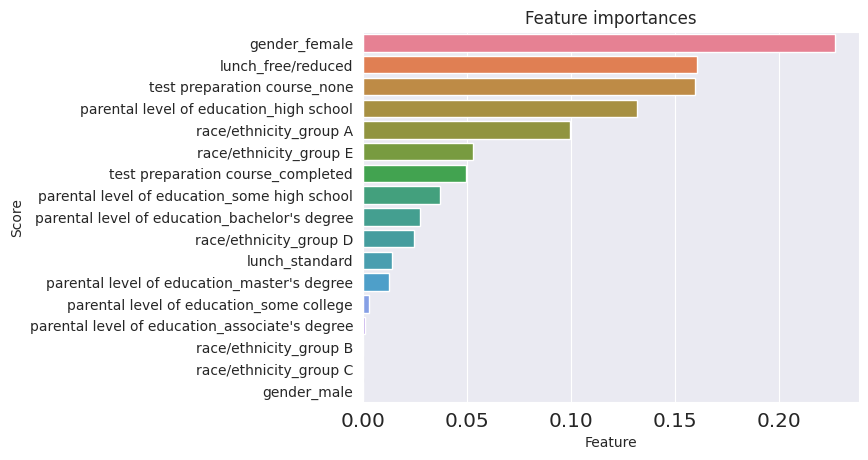

In [60]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=3, max_depth=4)
rf.fit(X_bal_smote, y_bal_smote)
rf_predictions= rf.predict(X_test_under)

print(accuracy_score(y_test_under,rf_predictions))

feature_importances = pd.DataFrame(
    {"feature":list(X_train.columns), 'importances':rf.feature_importances_}
).sort_values('importances',ascending=False)

sns.barplot(feature_importances, x='importances',y='feature',hue='feature')
plt.title('Feature importances')
plt.xlabel('Feature')
plt.ylabel('Score')
plt.xticks(fontsize='x-large')
plt.show()

0.7941176470588235


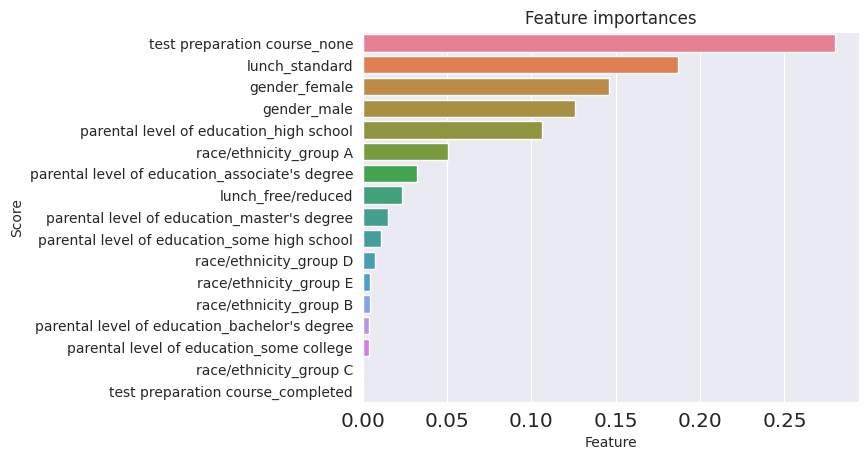

In [61]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=3, max_depth=4)
rf.fit(X_bal_smote, y_bal_smote)
rf_predictions= rf.predict(X_test_under)

print(accuracy_score(y_test_under,rf_predictions))


feature_importances = pd.DataFrame(
    {"feature":list(X_train.columns), 'importances':rf.feature_importances_}
).sort_values('importances',ascending=False)

sns.barplot(feature_importances, x='importances',y='feature',hue='feature')
plt.title('Feature importances')
plt.xlabel('Feature')
plt.ylabel('Score')
plt.xticks(fontsize='x-large')
plt.show()

# Conclusions
On this exam, the number of reproved students where in 11.4%

By seing the result of the Feature importances for both models we can make the next conclusions:

- The test preparation course is effective. and its presented as one of the main features to classify aproved and disaproved students in most of the models

- As in the reading exam the gender is also an important feature to most of the models. So is recomended to pay more attention to male students on this exam.

- Lunch type is also important on most of the RandomForest, including the one with the best accuaracy. So the recomendation on increasing the lunch to standart.

- The parents level of studies is highly important on Logistic regression model, but not in all the RandomForest models. Can be concluded that the same dispersion of the parents level of studies can be explained by another features

- The race also presented in most of the models. It seens that the group E tends to aprove, while group A to fail. Its recommended to give more classes to group A